# Port Scan Attachk Detection (LSTM Model)

In [2]:
# importing the Required Moudules

import os 
import math
import pandas as pd
import numpy as  np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore
from tensorflow.keras.models import Sequential, save_model, load_model, Model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.losses import MeanSquaredError # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # type: ignore

# Data Fetching

In [9]:
# Loading the Data Sets
main_dataset = pd.read_csv(r'C:\Users\srika\OneDrive\Desktop\DeepNet\Data\portscan copy.csv')

In [10]:
print(main_dataset.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [11]:
# Remove leading and trailing spaces from column names
main_dataset.columns = main_dataset.columns.str.strip()

# Define selected features correctly (without extra spaces)
selected_features = [
    'Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s', 'SYN Flag Count',
    'RST Flag Count', 'FIN Flag Count', 'ACK Flag Count', 'PSH Flag Count',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Min Packet Length',
    'Max Packet Length', 'Packet Length Std', 'Total Fwd Packets',
    'Total Backward Packets', 'Init_Win_bytes_forward',
    'Init_Win_bytes_backward', 'Subflow Fwd Packets', 'Subflow Bwd Packets'
]


targeted_feature = ["Label"]

# Select only existing features
dataset = main_dataset[selected_features]
targeted_dataset = main_dataset[targeted_feature]

# Convert labels (case-insensitive comparison)
targeted_dataset["Label"] = targeted_dataset["Label"].apply(lambda x: 0 if x.lower() == "benign" else 1)


C:\Users\srika\AppData\Local\Temp\ipykernel_12912\741359882.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeted_dataset["Label"] = targeted_dataset["Label"].apply(lambda x: 0 if x.lower() == "benign" else 1)


In [12]:
print(targeted_dataset.iloc[277750])

Label    1
Name: 277750, dtype: int64


In [13]:
print(dataset.head(10))
print(dataset.count())
print(targeted_dataset.head(10))
print(targeted_dataset.count())

   Flow Packets/s  Fwd Packets/s  Bwd Packets/s  SYN Flag Count  \
0       67.122468      32.376720      34.745748               0   
1       64.425518      31.075838      33.349680               0   
2    12500.000000    6250.000000    6250.000000               0   
3       63.675308      31.454068      32.221240               0   
4    38961.038960   12987.012990   25974.025970               0   
5     8196.721311    4098.360656    4098.360656               0   
6       61.962656      31.363813      30.598842               0   
7    36585.365850   12195.121950   24390.243900               0   
8    11695.906430    5847.953216    5847.953216               0   
9     9523.809524    4761.904762    4761.904762               0   

   RST Flag Count  FIN Flag Count  ACK Flag Count  PSH Flag Count  \
0               0               0               0               1   
1               0               0               0               1   
2               0               0               1      

In [14]:
print(dataset.head())
print(targeted_dataset.head())

   Flow Packets/s  Fwd Packets/s  Bwd Packets/s  SYN Flag Count  \
0       67.122468      32.376720      34.745748               0   
1       64.425518      31.075838      33.349680               0   
2    12500.000000    6250.000000    6250.000000               0   
3       63.675308      31.454068      32.221240               0   
4    38961.038960   12987.012990   25974.025970               0   

   RST Flag Count  FIN Flag Count  ACK Flag Count  PSH Flag Count  \
0               0               0               0               1   
1               0               0               0               1   
2               0               0               1               0   
3               0               0               0               1   
4               0               0               1               0   

   Flow IAT Mean   Flow IAT Std  Flow IAT Max  Min Packet Length  \
0    15075.50000  104051.399700        948537                  0   
1    15706.58333  104861.870100        955790 

# Data Pre-processing

In [15]:
# Checking Null Values
null_values = dataset.isnull().sum()
targeted_null_values = targeted_dataset.isnull().sum()
print("Null values in each column:\n", null_values)
print("Null values in each column:\n", targeted_null_values)

Null values in each column:
 Flow Packets/s             0
Fwd Packets/s              0
Bwd Packets/s              0
SYN Flag Count             0
RST Flag Count             0
FIN Flag Count             0
ACK Flag Count             0
PSH Flag Count             0
Flow IAT Mean              0
Flow IAT Std               0
Flow IAT Max               0
Min Packet Length          0
Max Packet Length          0
Packet Length Std          0
Total Fwd Packets          0
Total Backward Packets     0
Init_Win_bytes_forward     0
Init_Win_bytes_backward    0
Subflow Fwd Packets        0
Subflow Bwd Packets        0
dtype: int64
Null values in each column:
 Label    0
dtype: int64


# Data Normalization

In [16]:
# Normalize dataset
column = ['Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s', 'SYN Flag Count',
    'RST Flag Count', 'FIN Flag Count', 'ACK Flag Count', 'PSH Flag Count',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Min Packet Length',
    'Max Packet Length', 'Packet Length Std', 'Total Fwd Packets',
    'Total Backward Packets', 'Init_Win_bytes_forward',
    'Init_Win_bytes_backward', 'Subflow Fwd Packets', 'Subflow Bwd Packets']

# Check for NaN or infinite values
print("Checking for NaN or infinite values...")
print(dataset[column].isnull().sum())  # NaN check
print(np.isinf(dataset[column]).sum())  # Infinite check

# Replace infinite values with NaN
dataset[column] = dataset[column].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
dataset = dataset.dropna(subset=column)

# Check for constant columns
print("Unique values in each column:")
print(dataset[column].nunique())

Checking for NaN or infinite values...
Flow Packets/s             0
Fwd Packets/s              0
Bwd Packets/s              0
SYN Flag Count             0
RST Flag Count             0
FIN Flag Count             0
ACK Flag Count             0
PSH Flag Count             0
Flow IAT Mean              0
Flow IAT Std               0
Flow IAT Max               0
Min Packet Length          0
Max Packet Length          0
Packet Length Std          0
Total Fwd Packets          0
Total Backward Packets     0
Init_Win_bytes_forward     0
Init_Win_bytes_backward    0
Subflow Fwd Packets        0
Subflow Bwd Packets        0
dtype: int64
Flow Packets/s             371
Fwd Packets/s                0
Bwd Packets/s                0
SYN Flag Count               0
RST Flag Count               0
FIN Flag Count               0
ACK Flag Count               0
PSH Flag Count               0
Flow IAT Mean                0
Flow IAT Std                 0
Flow IAT Max                 0
Min Packet Length          

C:\Users\srika\AppData\Local\Temp\ipykernel_12912\623634990.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column] = dataset[column].replace([np.inf, -np.inf], np.nan)


In [17]:
# Apply MinMaxScaler
scaler = MinMaxScaler()
dataset[column] = scaler.fit_transform(dataset[column])

# Round to 6 decimals
dataset[column] = np.round(dataset[column], decimals=5)

# Verify scaling
print("Minimum values after scaling:")
print(dataset[column].min())
print("Maximum values after scaling:")
print(dataset[column].max())

# Verify unique values
print("Unique values in scaled dataset:")
print(np.unique(dataset[column].values))

Minimum values after scaling:
Flow Packets/s             0.0
Fwd Packets/s              0.0
Bwd Packets/s              0.0
SYN Flag Count             0.0
RST Flag Count             0.0
FIN Flag Count             0.0
ACK Flag Count             0.0
PSH Flag Count             0.0
Flow IAT Mean              0.0
Flow IAT Std               0.0
Flow IAT Max               0.0
Min Packet Length          0.0
Max Packet Length          0.0
Packet Length Std          0.0
Total Fwd Packets          0.0
Total Backward Packets     0.0
Init_Win_bytes_forward     0.0
Init_Win_bytes_backward    0.0
Subflow Fwd Packets        0.0
Subflow Bwd Packets        0.0
dtype: float64
Maximum values after scaling:
Flow Packets/s             1.0
Fwd Packets/s              1.0
Bwd Packets/s              1.0
SYN Flag Count             1.0
RST Flag Count             1.0
FIN Flag Count             1.0
ACK Flag Count             1.0
PSH Flag Count             1.0
Flow IAT Mean              1.0
Flow IAT Std              

In [18]:
print("First 5 rows of normalized dataset:")
print(dataset[column].head())

print("Checking min/max values in scaled dataset:")
print("Min values:", dataset[column].min().values)
print("Max values:", dataset[column].max().values)


First 5 rows of normalized dataset:
   Flow Packets/s  Fwd Packets/s  Bwd Packets/s  SYN Flag Count  \
0         0.40001        0.00001        0.00002             0.0   
1         0.40001        0.00001        0.00002             0.0   
2         0.40250        0.00208        0.00312             0.0   
3         0.40001        0.00001        0.00002             0.0   
4         0.40779        0.00433        0.01299             0.0   

   RST Flag Count  FIN Flag Count  ACK Flag Count  PSH Flag Count  \
0             0.0             0.0             0.0             1.0   
1             0.0             0.0             0.0             1.0   
2             0.0             0.0             1.0             0.0   
3             0.0             0.0             0.0             1.0   
4             0.0             0.0             1.0             0.0   

   Flow IAT Mean  Flow IAT Std  Flow IAT Max  Min Packet Length  \
0        0.00015       0.00123       0.00790                0.0   
1        0.0

In [19]:
target_scaler = MinMaxScaler()
targeted_dataset['Label'] = target_scaler.fit_transform(targeted_dataset[['Label']])
targeted_dataset.head()

C:\Users\srika\AppData\Local\Temp\ipykernel_12912\497236672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeted_dataset['Label'] = target_scaler.fit_transform(targeted_dataset[['Label']])


,Label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [20]:
print(targeted_dataset.iloc[277750])

Label    1.0
Name: 277750, dtype: float64


# Functions to check the File Size 

In [21]:
def get_file_size(file_path):
  size = os.path.getsize(file_path)
  return size

In [22]:
def convert_bytes(size, unit=None):
  if unit == 'KB':
    return print(f'File Size is : {size / 1024:.2f} KB')
  elif unit == 'MB':
    return print(f'File Size is : {size / (1024 * 1024):.2f} MB')

# Creating Time Series Sequence & Splitinf the Data

In [23]:
# Function to create sequences
def create_sequences(column_data, time_steps):
    X, Y = [], []
    for i in range(len(column_data) - time_steps):
        X.append(column_data[i:i + time_steps])
        Y.append(column_data[i + time_steps])
    return np.array(X), np.array(Y).reshape(-1, 1)

# Define time steps (e.g., last 25 records to predict the next)
column_data = dataset[['Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s', 'SYN Flag Count',
    'RST Flag Count', 'FIN Flag Count', 'ACK Flag Count', 'PSH Flag Count',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Min Packet Length',
    'Max Packet Length', 'Packet Length Std', 'Total Fwd Packets',
    'Total Backward Packets', 'Init_Win_bytes_forward',
    'Init_Win_bytes_backward', 'Subflow Fwd Packets', 'Subflow Bwd Packets']].values
time_steps = 15

X , _ = create_sequences(column_data, time_steps)

targeted_column = targeted_dataset['Label'].values
_ , y = create_sequences(targeted_column, time_steps)


print(f"Shape of X_Sequence: {X.shape}")
print(f"Values of X_Sequence: {X}")
print(f"Shape of y_Sequence: {y.shape}")
print(f"Values of y_Sequence: {y}")


Shape of X_Sequence: (286081, 15, 20)
Values of X_Sequence: [[[4.0001e-01 1.0000e-05 2.0000e-05 ... 3.7200e-03 1.2830e-02 1.2100e-02]
  [4.0001e-01 1.0000e-05 2.0000e-05 ... 3.7200e-03 1.2830e-02 1.2100e-02]
  [4.0250e-01 2.0800e-03 3.1200e-03 ... 3.7200e-03 0.0000e+00 2.8000e-04]
  ...
  [6.0000e-01 3.3333e-01 0.0000e+00 ... 0.0000e+00 3.2000e-04 0.0000e+00]
  [4.0015e-01 1.8000e-04 1.1000e-04 ... 5.4600e-03 4.4900e-03 1.6500e-03]
  [4.0006e-01 4.0000e-05 8.0000e-05 ... 3.5100e-03 5.7700e-03 6.8800e-03]]

 [[4.0001e-01 1.0000e-05 2.0000e-05 ... 3.7200e-03 1.2830e-02 1.2100e-02]
  [4.0250e-01 2.0800e-03 3.1200e-03 ... 3.7200e-03 0.0000e+00 2.8000e-04]
  [4.0001e-01 1.0000e-05 2.0000e-05 ... 3.7200e-03 1.2830e-02 1.1550e-02]
  ...
  [4.0015e-01 1.8000e-04 1.1000e-04 ... 5.4600e-03 4.4900e-03 1.6500e-03]
  [4.0006e-01 4.0000e-05 8.0000e-05 ... 3.5100e-03 5.7700e-03 6.8800e-03]
  [5.5000e-01 2.5000e-01 0.0000e+00 ... 0.0000e+00 6.4000e-04 0.0000e+00]]

 [[4.0250e-01 2.0800e-03 3.1200e-03 

In [24]:
# Ensure X and y have the same number of samples
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Split the data into training and testing sets
train_size = int(len(X) * 0.90)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes to verify
print(f"Training data size: {train_size}, Testing data size: {test_size}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Training data size: 257472, Testing data size: 28609
X_train shape: (257472, 15, 20)
X_test shape: (28609, 15, 20)
y_train shape: (257472, 1)
y_test shape: (28609, 1)


# Model Creation

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define model
model = Sequential()

# First LSTM layer with dropout and regularization
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005), input_shape=(time_steps, 20)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Second LSTM layer
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping & LR scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Print model summary
model.summary()


c:\Users\srika\OneDrive\Desktop\DeepNet\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 64)         │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,521 (232.50 KB)

 Trainable params: 59,265 (231.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [96]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/50
3219/3219 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.9743 - loss: 0.1635 - val_accuracy: 0.8712 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 2/50
3219/3219 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - accuracy: 0.9798 - loss: 0.1058 - val_accuracy: 0.8717 - val_loss: 0.5852 - learning_rate: 0.0010
Epoch 3/50
3219/3219 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - accuracy: 0.9803 - loss: 0.1000 - val_accuracy: 0.8714 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 4/50
3219/3219 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - accuracy: 0.9803 - loss: 0.0975 - val_accuracy: 0.8712 - val_loss: 0.5557 - learning_rate: 0.0010
Epoch 5/50
3219/3219 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - accuracy: 0.9806 - loss: 0.0973 - val_accuracy: 0.8710 - val_loss: 0.5796 - learning_rate: 0.0010
Epoch 6/50
3219/3219 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - accuracy: 0.9805 - loss: 0.0961 - val_accuracy: 0.8716 - val_loss: 0.5762 - learning_rate: 0.0010
Epoch 7/50
3219/3219 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - accura

# Predicting the Model

In [26]:
# Get model predictions
train_predictions = model1.predict(X_test)

# Rescale predictions and reshape to (28609, 1)
train_prediction = target_scaler.inverse_transform(train_predictions).reshape(-1, 1)

# Rescale actual values and reshape to (28609, 1)
y = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, 1)

# Convert predictions to 0 or 1 based on threshold
binary_predictions = np.where(train_prediction <= 0.5, 0, 1)

# Store results in DataFrame
train_results = pd.DataFrame(data={
    'Train Predictions': binary_predictions.flatten(),  # flatten for a clean DataFrame
    'Actuals': y.flatten()
})

print(train_results)

895/895 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
       Train Predictions  Actuals
0                      0      0.0
1                      0      0.0
2                      0      0.0
3                      0      0.0
4                      0      0.0
...                  ...      ...
28604                  0      0.0
28605                  0      0.0
28606                  0      0.0
28607                  0      0.0
28608                  0      0.0

[28609 rows x 2 columns]


In [111]:
print(f"Shape of train_prediction: {train_prediction.shape}")
print(f"Shape of y: {y.shape}")

Shape of train_prediction: (28609, 1)
Shape of y: (28609, 1)


# Model Accuracy and Loss Values

In [112]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5474 - loss: 0.7944
Test Loss: [0.7942207455635071, 0.5728616714477539]


In [113]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy score
accuracy = accuracy_score(y_true=y.flatten(), y_pred=binary_predictions.flatten())
print(f"Accuracy: {accuracy:.4f}")

# Classification report (optional - shows precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y.flatten(), binary_predictions.flatten()))


Accuracy: 0.5729

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.45      0.59     19582
         1.0       0.41      0.84      0.55      9027

    accuracy                           0.57     28609
   macro avg       0.63      0.64      0.57     28609
weighted avg       0.72      0.57      0.58     28609



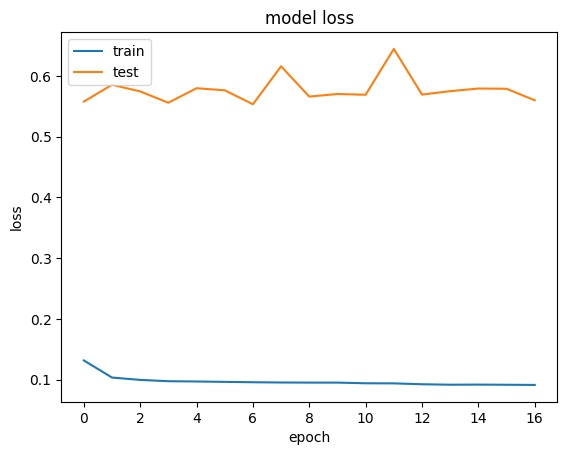

In [114]:
# Plot the Loss Graph
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

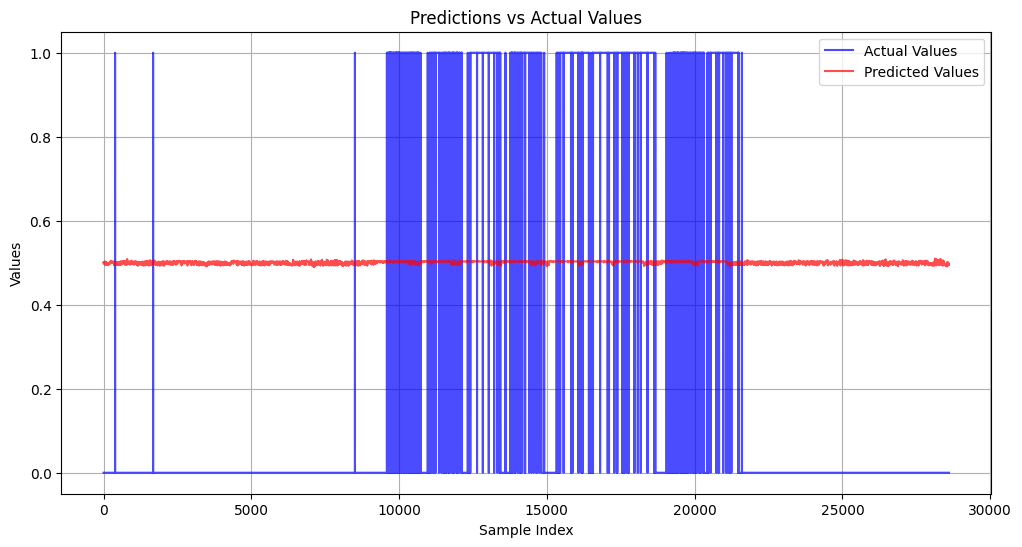

In [115]:
# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual Values', color='blue', alpha=0.7)
plt.plot(train_prediction, label='Predicted Values', color='red', alpha=0.7)
plt.title('Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [116]:
rmse = math.sqrt(mean_squared_error(y, train_prediction))
mae = mean_absolute_error(y, train_prediction)
mape = mean_absolute_percentage_error(train_prediction, y)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 0.4994334788859237
MAE: 0.4994254964936546
MAPE: 0.9976468664002563


# Model Saving

In [104]:
model.save(r'C:\Users\srika\OneDrive\Desktop\DeepNet\h5\Port_Model.h5')

In [6]:
convert_bytes(get_file_size(r'C:\Users\srika\OneDrive\Desktop\DeepNet\h5\Port_Model.h5'), 'KB')

File Size is : 759.72 KB


In [7]:
model1 = load_model(r'C:\Users\srika\OneDrive\Desktop\DeepNet\h5\Port_Model.h5')

# Tensor Flow Model Creation

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open(r'C:\Users\srika\OneDrive\Desktop\DeepNet\tflites\port_scan_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\srika\AppData\Local\Temp\tmpr6ce96n6\assets


INFO:tensorflow:Assets written to: C:\Users\srika\AppData\Local\Temp\tmpr6ce96n6\assets


Saved artifact at 'C:\Users\srika\AppData\Local\Temp\tmpr6ce96n6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15, 20), dtype=tf.float32, name='input_layer_12')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2253118114128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118116240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118116048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118115280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118115856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118117776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118115664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118120080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118122000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2253118122576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22531181

# Predicting the Model Using the Tflite Model

In [29]:
interpreter = tf.lite.Interpreter(model_path=r'C:\Users\srika\OneDrive\Desktop\DeepNet\tflites\port_scan_model.tflite')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

predicted_values = []
true_values = []

print(input_details)
print(output_details)

for i in range(len(X_test)):
    cnn_input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], cnn_input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_values.append(output_data[0][0])
    true_values.append(y_test[i])

predicted_values = np.array(predicted_values)
true_values = np.array(true_values)


predicted_values_reshaped = predicted_values.reshape(-1, 1)
predictions_rescaled = target_scaler.inverse_transform(predicted_values_reshaped).flatten()

y_test_reshaped = true_values.reshape(-1, 1)
y_test_rescaled = target_scaler.inverse_transform(y_test_reshaped).flatten()

results = pd.DataFrame(data={'Predictions': predictions_rescaled, 'Actuals': y_test_rescaled})
print(results)

c:\Users\srika\OneDrive\Desktop\DeepNet\env\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


[{'name': 'serving_default_input_layer_12:0', 'index': 0, 'shape': array([ 1, 15, 20], dtype=int32), 'shape_signature': array([-1, 15, 20], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 51, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
       Predictions  Actuals
0         0.006368      0.0
1         0.006570      0.0
2         0.005641      0.0
3         0.006186      0.0
4         0.005995      0.0
...            ...      ...
28604     0.009937      0.0
28605     0.007463      0.0
28606     0.005221

In [30]:
optimized_rmse = math.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
optimized_mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
optimized_mape = mean_absolute_percentage_error(predictions_rescaled, y_test_rescaled)

print("Optimized RMSE:", optimized_rmse)
print("Optimized MAE:", optimized_mae)
print("Optimized MAPE:", optimized_mape)

Optimized RMSE: 0.4075004298825435
Optimized MAE: 0.17990956137792719
Optimized MAPE: 13.357912838729668


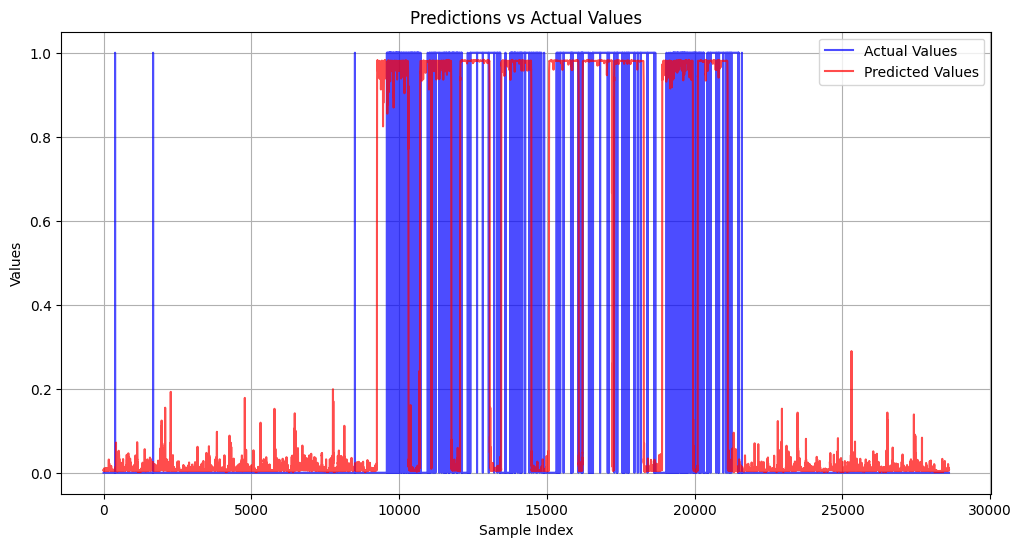

In [31]:
# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Values', color='blue', alpha=0.7)
plt.plot(predictions_rescaled, label='Predicted Values', color='red', alpha=0.7)
plt.title('Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()